# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Цель исследования:

    1) Проанализировать данные по рынку недвижимости
    2)Определить факторы влияющие на стоимость недвижимости 

Ход исследования:
    
    1)Обзор данных
    2)Выявление пропусков и недостоверных данных 
    3)Форматирование данных перед обработкой
    4)Проведение исследования
    5)Вывод

### Откройте файл с данными и изучите общую информацию. 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

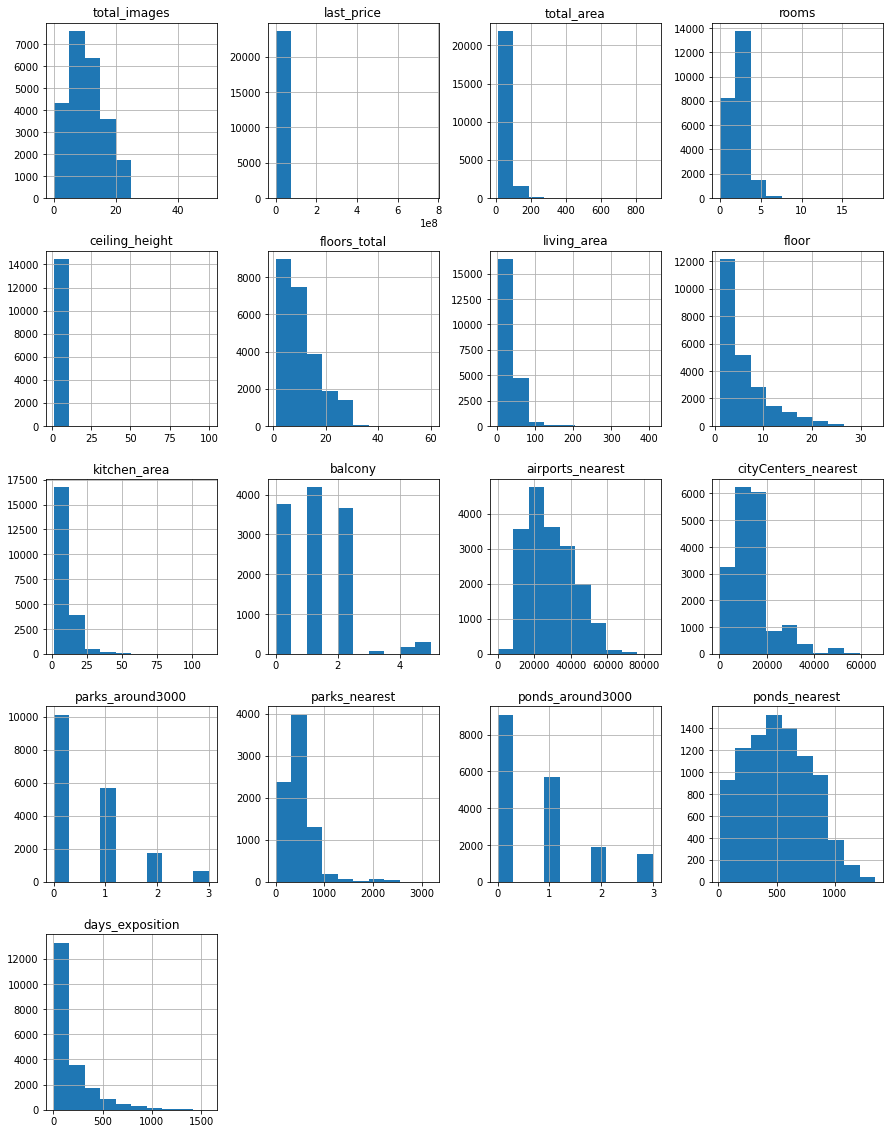

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
display(data.head())
data.info()
data.hist(figsize=(15, 20));

Вывод: Первичный анализ данных показал что во многих пунктах отсутствуют значения, некотрые данные имеют неподходящий тип данных 

In [2]:
#изменение информации о пропусках балконов на 0
data['balcony'].fillna(0, inplace=True)

#изменение информации про водоёмы и парки на 0
data['parks_around3000'].fillna(0, inplace=True)
data['ponds_around3000'].fillna(0, inplace=True)

#изменение типа данных в is_apartment на bool для возможности отобразить данные правильно 
data['is_apartment'] = data['is_apartment'].astype('bool')

#переводим дату публикации в формат дата:время
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")

# замена значений  в locality_name (самое очевидное)
data['locality_name'] = data['locality_name'].str.replace('городской посёлок', 'посёлок городского типа')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'посёлок городского типа')
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок')

#замена расстояний до центра на медианное 
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())


In [3]:
#медиана высоты потолков     
ceiling_height_median = data.query('2.3 <= ceiling_height <= 6')['ceiling_height'].median()
 
#задаём функцию для замены аномальной высоты потолков
def anomaly_height (ceiling_height):
    if ceiling_height >= 30 and ceiling_height <= 50:  #исключаем ишибку написания высоты потолка 
        ceiling_height *= 0.1
    elif ceiling_height > 4:
        ceiling_height = ceiling_height_median
    return ceiling_height

data_ceiling_height = data['ceiling_height'] #новая переменная чтобы не запустаться в скобках
for i in range(len(data_ceiling_height)):
    data_ceiling_height[i] = anomaly_height(data_ceiling_height[i])
data['ceiling_height'] = data_ceiling_height
 
#заменяем пустые значения высоты потолков на медианное значение
data['ceiling_height'].fillna(ceiling_height_median, inplace=True)

/tmp/ipykernel_31/1351339865.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ceiling_height[i] = anomaly_height(data_ceiling_height[i])


In [4]:
# пропуски в этажах заменим на медианное значение 
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

In [5]:
# средняя жилая площадь без пропусков 
living_area_mean = data[data['living_area'].isnull() == False]['living_area'].mean()

# средняя общая площадь без пропусков 
total_area_mean = data[data['total_area'].isnull() == False]['total_area'].mean()

#коэффицент соотношеиня общей к жилой 
k = total_area_mean / living_area_mean

# жилая площадь умноженая на коэффицент площади
living_area_full = data['total_area']*k

#пропусков с погрешностью на коэффицент
data['living_area'] = data['living_area'].fillna(living_area_full)

# аномально низкие площади заменим на среднее
def min_area (living_area):
    if living_area < 4:
        living_area *= 10
    return living_area
data['living_area'].fillna(min_area, inplace=True) #не понимаю почему не менется, буду надеяться на ваш коментарий
    
display(living_area_mean)
data['living_area'].min()

34.457852427601395

2.0

In [6]:
#средняя площадь кухни 
median_kitchen_area = data['kitchen_area'].median() #получилось 9.1 (по СП 54.13330.2011 минимальная площадь кухни 8м)
#пропуски на медианое значение 
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
data['kitchen_area'] = round(data['kitchen_area'],2) #уберем знаки после зяпятой 
# так же можно добавить функцию для переасчета тех площадей которые анамально низкикими либо просто удалить их и вставить на их место медианное знаячение


На данном этапе не буду заполнять пропуски в расстоянях до аэропорта, парков и прудов. 
Так же пропуски в дне публикации скорее всего не смогу заполнить потому то не хватает данных 

Изменил тип данных в этажах и посмотрел уникальные значения дупликатов. но на самом деле бывают этажи типо 3,5 (в старых домах в питере такое встречается часто) 

In [7]:
#изменение типа данных этажности здания (округляем до целого и меняем тип)
data['floors_total'] = data['floors_total'].round(0).astype('int')

In [8]:
#проверка на явные дупликаты
data.duplicated().unique()


array([False])

In [9]:
data.isnull().sum() #таблица пропусков по столбцам

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest         0
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

Промежуточный вывод: пробелы или аномальные значеиня данных могли возникнуть во время заполнения датасета. строки заполнялись не одним человеком а были взяты из архива объявлений пользователей, которые могли ошибиться при вводе информаци, указав данные не в том формате записи либо вообще не указыватьт часть данных. Так же была убрана часть неявных дубликатов в названиях данных. 

### Посчитайте и добавьте в таблицу новые столбцы

In [10]:
# медианная цена одного квадратного метра 
data['median_area_price'] = (data['last_price'] / data['total_area'])
data['median_area_price'] = round(data['median_area_price'],2) #уберем знаки после зяпятой 

In [11]:
#добавление столбцов день, месяц, год 
data['day'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data['day_of_week'] = data['first_day_exposition'].dt.day_name

In [12]:
# функция для подсчета этажей     
def floor_number_def(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    return 'другой'
data['floor_type']= data.apply(floor_number_def, axis=1)    

In [13]:
#переведем метры в километры в столбце расстояние до центра
data['cityCenters_nearest'] = data['cityCenters_nearest'] * 0.001
data['cityCenters_nearest'] = round(data['cityCenters_nearest']) #уберем знаки после зяпятой 

In [14]:
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,median_area_price,day,month,year,day_of_week,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,True,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,<bound method PandasDelegate._add_delegate_acc...,другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,True,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,<bound method PandasDelegate._add_delegate_acc...,первый
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,True,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,<bound method PandasDelegate._add_delegate_acc...,другой
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,278.468762,9,True,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,<bound method PandasDelegate._add_delegate_acc...,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,True,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,<bound method PandasDelegate._add_delegate_acc...,другой


Промежуточный вывод: в дадасет были добавлены новые столбцы с данными. такими как дата публикации с днем недели, присвоены новые значения уровню этажа, посдчитаны стоимоть одного квадратного метра. расстояние до центра было переведено в киллометры 

### Проведите исследовательский анализ данных

<AxesSubplot:>

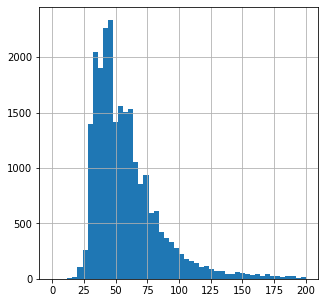

In [15]:
#гистограмма по общей площади 
data['total_area'].hist(bins=50,figsize=(5, 5), range=(0,200))

на рынке неджижимости в основном предствалены квартиры от 30 до 200 метров квадратных. эт обусловлено в первую очередь плежеспособностью клиентов. застройщикам невыгодно стоить квартиры которые никто не купит 

<AxesSubplot:>

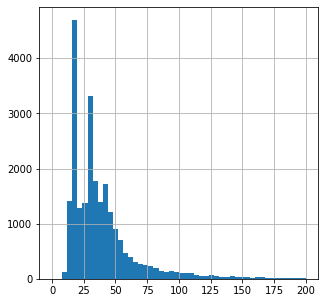

In [16]:
#гистограмма по жилой площади
data['living_area'].hist(bins=50,figsize=(5, 5), range=(0, 200))

преобладающая площадь варируется, в основном это квартиры с 1-2 комнатам, так же присутствуют кваритры студии 

<AxesSubplot:>

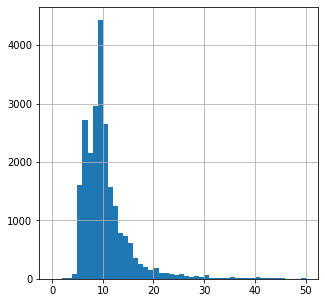

In [17]:
#гистограмма по площади кухни 
data['kitchen_area'].hist(bins=50,figsize=(5, 5), range=(0,50))

такая же ситуация как и с жилой площадью, возрастание площади кухни при возрастании общей площади квартиры. на графике присуттвуют квартиры студии

<AxesSubplot:>

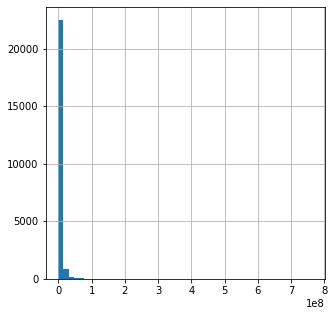

In [18]:
#гистограмма по цене объекта
data['last_price'].hist(bins=50,figsize=(5, 5))


<AxesSubplot:>

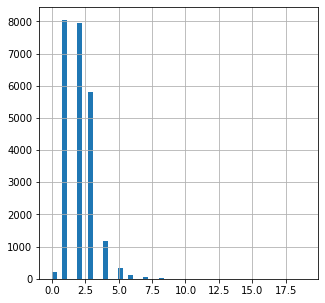

In [19]:
#гистограмма по количетву комнат
data['rooms'].hist(bins=50,figsize=(5, 5))

0 комнат это скорее всего квартиры студии 

1-3 комнаты самый распространный вариант строительства. так же набрали популярность так называемы евродвухки, где комната и большая кухня-гостинная

4 и более уже более дорогой сегмент, с большИми площадами и другим классом застройки 

<AxesSubplot:>

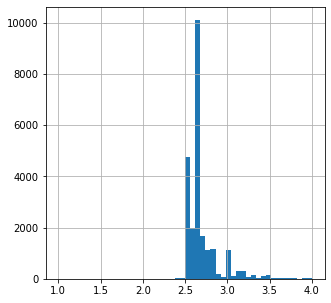

In [20]:
#гистограмма по высоте потолков
data['ceiling_height'].hist(bins=50,figsize=(5, 5))

потолки 2.25 - цокольные этажи ( полуподвальные), большая масса квартир - 2.65,  присутствуют квартиры с потолками выше 3 метров это старые зданиея либо квартры класса премиум 

<AxesSubplot:>

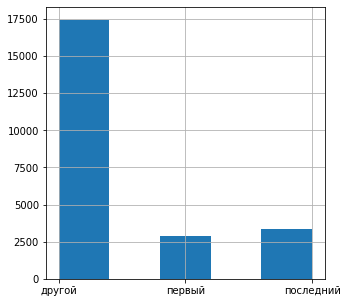

In [21]:
#гистограмма по этажу квартиры 
data['floor_type'].hist(bins=5,figsize=(5, 5))

<AxesSubplot:>

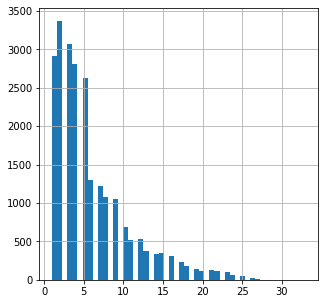

In [22]:
#гистограмма по типу этажности квартиры 
data['floor'].hist(bins=50,figsize=(5, 5))

1 этаж комерчиские организации 

2-6 этаж выше уровень шума от улицы, но и кислорода больше

7-14  этажи не так шумно и меньше пыли, но воздух менее насыщен кислородом

последние этажи как правило с самыми высокими потолками и иногда с большой площадью либо двухъярусные

<AxesSubplot:>

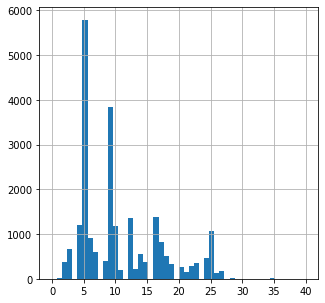

In [23]:
#гистограмма по общему количеству этажей дома 
data['floors_total'].hist(bins=50,figsize=(5, 5), range=(0,40))

заметна тенденция уменьшения количества домов с высокой этажностью. это обусловлено тем, что в черте города запрещено стоить высокоэтажные дома чтобы не нарушать уровень застройки, поэтому 2-12 этажные дома самые популярные. 
дома с этажностью от 15 и выше начинаются ближе к границам города и в области, часто такие дома имеют от 5 до 20 парадных поэтому и их количество не так велико. 

<AxesSubplot:>

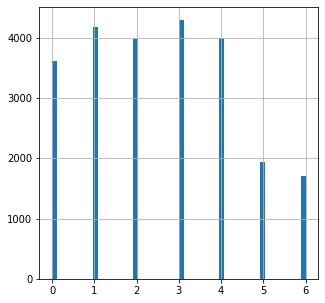

In [24]:
#гистограма по дню недели
data['day'].hist(bins=50,figsize=(5, 5))

<AxesSubplot:>

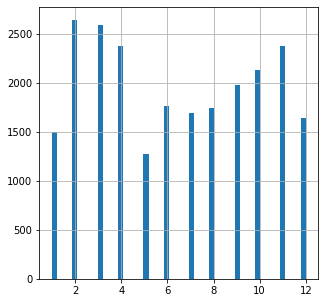

In [25]:
#гистограма по месяцу
data['month'].hist(bins=50,figsize=(5, 5))

<AxesSubplot:>

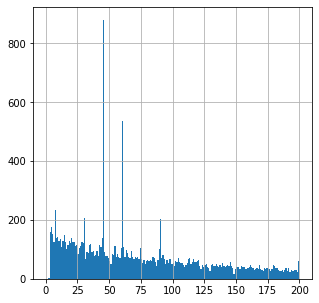

In [26]:
#Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление
# среднее (180)
days_exposition_mean = data[data['days_exposition'].isnull() == False]['days_exposition'].mean()
#медианное (95)
days_exposition_median = data[data['days_exposition'].isnull() == False]['days_exposition'].median()
#print(days_exposition_mean)
#print(days_exposition_median)

data['days_exposition'].hist(bins=200, figsize=(5, 5), range=(0, 200))


в среднем продажа квартиры заниеи 180 дней, медиана продажи квартиры 95 дней.

анамальные быстрые продажи - продажи в первые дни публикации, продажи на этапе котлована. 

быстрой продажей квартиры можно назвать продажи совершенные за 50-100 календарных дней, это хорошие предложения по цене за квадратный метр, хорошее расположение и тд

долгая продажа 100-300 дней 

необычно долгие продажи свыше 300 дней, не так часто продаются квартиры с очень высокой стоимостью. а те у кого есть такие финансы будут тщательно выбирать подходящий им вариант 

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

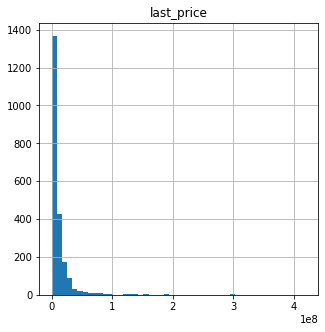

In [27]:
#Какие факторы больше всего влияют на общую (полную) стоимость объекта? 

total_area_pivot = data.pivot_table(index='total_area', values='last_price') 
living_area_pivot = data.pivot_table(index='living_area', values='last_price')
kitchen_area_pivot = data.pivot_table(index='kitchen_area', values='last_price')
rooms_pivot = data.pivot_table(index='rooms', values='last_price')
floor_type_pivot = data.pivot_table(index='floor_type', values='last_price')
#display(total_area_pivot, living_area_pivot, kitchen_area_pivot, rooms_pivot, floor_type_pivot)


total_area_pivot.hist(bins=50, figsize=(5,5))

In [28]:
#корреляция Пирсона для площадей
print('корреляция общей площади', data['total_area'].corr(data['last_price']))
print('корреляция жилой площади', data['living_area'].corr(data['last_price']))
print('корреляция площади кухни', data['kitchen_area'].corr(data['last_price']))


корреляция общей площади 0.6536750579657242
корреляция жилой площади 0.4505069784796024
корреляция площади кухни 0.44031561243446554


In [29]:
total_area_pivot = total_area_pivot.reset_index()

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

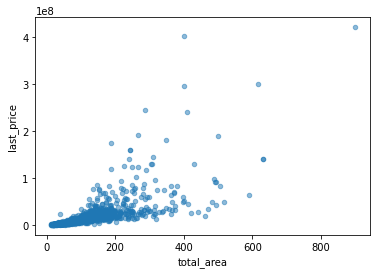

In [30]:
#график рассеяния для общей площади  
total_area_pivot.plot(kind='scatter', x='total_area', y='last_price', alpha=0.5)

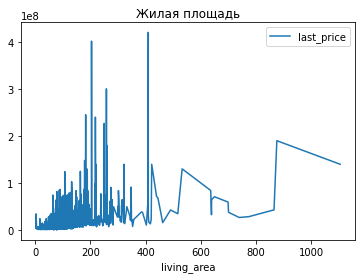

In [31]:
#жилая площадь
living_area_pivot = living_area_pivot.reset_index()
living_area_pivot.plot(kind='line', x='living_area', y='last_price')
plt.title('Жилая площадь');

Неоднозначный график стоимости отт жилой площади. Выбросы либо означают что жилье ну очень с хорошей планировкой и в новом доме бизнес класса. Либо это страя застройка с совмещенными комуналками и ты будешь жить один на этаже. 

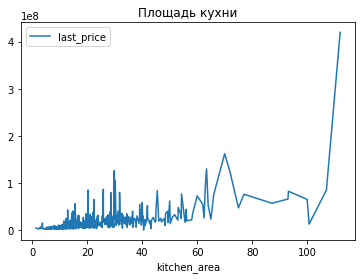

In [32]:
#площадь кухни
kitchen_area_pivot = kitchen_area_pivot.reset_index()
kitchen_area_pivot.plot(kind='line',x='kitchen_area', y='last_price')
plt.title('Площадь кухни');

С возрастанием цены по ходу увеличения площади кухни все проще. Не так много пиковых значений которые сильно выбивались бы из общей картины. Скорее всего это особенности данных квартир в хорошей планировке и удобной кухне

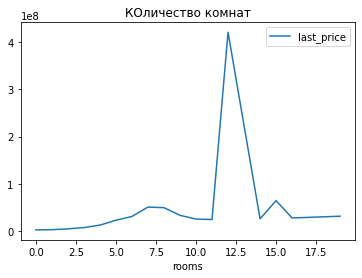

In [33]:
#Количество комнат
rooms_pivot = rooms_pivot.reset_index()
rooms_pivot.plot(kind='line', x='rooms', y='last_price')
plt.title('КОличество комнат');

Плавный рост цены до 11 комнат и такой резкий скачек на уровне 11-14 комнат. ДАже не знаю с чем это может бысть связано, какой-то элитный район большим количиством одинаковых планировок по завышенной цене за счет месторасположения или статуса застройщика. 

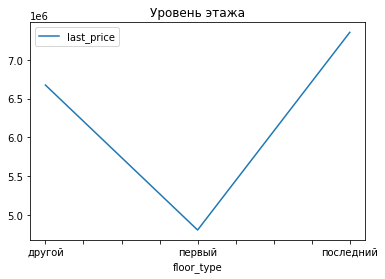

In [34]:
#уровень этажа
floor_type_pivot = floor_type_pivot.reset_index()
floor_type_pivot.plot(kind='line', x='floor_type', y='last_price')
plt.title('Уровень этажа');

Первые этажи дешевле потому что мало кто хочет там жить да и в основном это комерческие помещения. Самые дорогие квартиры на последних этажах. Обсусловлено более высокми потолками либо наличием террасы, либо вообще двухуровневой квартирой. 

Больше всего на общую стоимость влияют: общая площадь квартиры, количество комнат. В меньшей степени то на каком этаже квартира находится ( если не брать в учет квартиры с каким-то потрясающим видом) 

<AxesSubplot:>

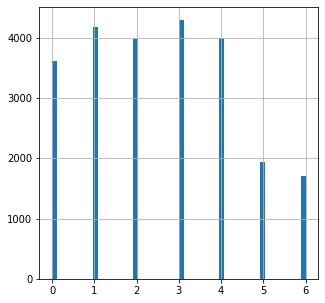

In [35]:
#график по дню недели
data['day'].hist(bins=50,figsize=(5, 5))

если учесть что 0 - это понедельник, а 6 - воскресенье, то в выходные дни не так охотно выкладывали объявления. видимо все время тратили на отдых

<AxesSubplot:>

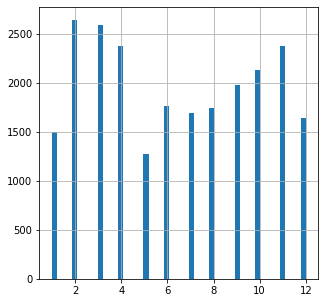

In [36]:
#график по месяцу публикации
data['month'].hist(bins=50,figsize=(5, 5))

рост продаж с февраля по апреля может быть вызван либо акциями от застройщиков, либо тем что многим выдают премию как 13 зарплату и они подкопив первый взнос либо всю сумму оплачивали. как мы поняли в мае все на дачах готовятся к теплому сезону. а вот рост продаж жилья осенью на данный момент могу объяснить только тем что люди заранее позаботились о том чтобы было где отпраздновать новый год, так еще и месяц на ремонт оставили

<AxesSubplot:>

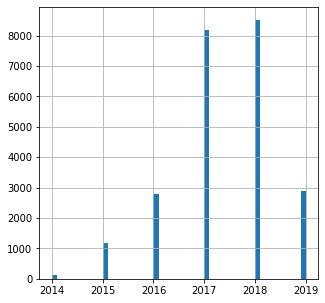

In [37]:
#график по году публикации
data['year'].hist(bins=50,figsize=(5, 5))

в 2014-2015 году был валютный кризис, в 2016 году застройщики поняли что мало строили и земля не такая дорогая как была раньше. в 2017-2018 по данынм МЦФ стоимость жилья упала, вот он и пик продаж. в 2019 цены начали подниматься да и уровень застройки изменился, скорее всего это причина спада продаж. 

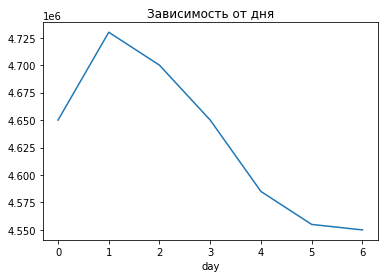

In [38]:
#день недели
data.groupby('day')['last_price'].median().plot();
plt.title('Зависимость от дня');

в начале недели выкладывают более дорогие картиры. даже нет идей почему так происходит 

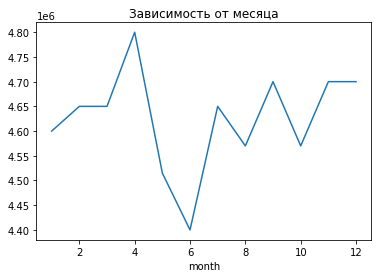

In [40]:
#месяц
data.groupby('month')['last_price'].median().plot();
plt.title('Зависимость от месяца');

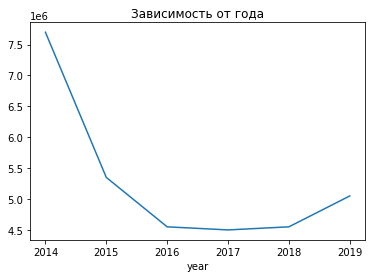

In [41]:
#год
data.groupby('year')['last_price'].median().plot();
plt.title('Зависимость от года');

In [ ]:
#Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах 
data['one_meter_price'] = data['last_price'] / data['total_area']
data['one_meter_price'] = round(data['one_meter_price'],2)

#сортировка по количеству объявлений и средней цене
exp_town = data.groupby('locality_name').agg({'one_meter_price':['count', 'median']})
exp_town.columns = [ 'count_exp', 'median_price']

display(exp_town.sort_values('count_exp', ascending=False).head(10))

max_exp_town = data[['locality_name', 'one_meter_price']]
display(max_exp_town.sort_values('one_meter_price',ascending=False).head())

min_exp_town = data[['locality_name', 'one_meter_price']]
display(min_exp_town.sort_values('one_meter_price',ascending=False).tail())

самой высокой стоимостью за квадратный метр является Санкт-Петербург

самой низкой стоимостью за квадратный метр является поселок станции Свирь

In [ ]:
data.iloc[[8793]] 

In [ ]:
display(data['cityCenters_nearest'])

In [ ]:
#цена одного километра 
data['one_km_price'] = data['last_price'] / data['cityCenters_nearest']
data['one_km_price'] = round(data['one_km_price'],2)


#spb_km_price_pivot = data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest', values='one_km_price').round(0).reset_index()
#display(spb_km_price_pivot)

spb_km_price = data.query('locality_name=="Санкт-Петербург"').groupby('cityCenters_nearest')['last_price'].mean().round(0).reset_index()

spb_km_price.columns = ['cityCenters_nearest','one_km_price']
display(spb_km_price.head())
spb_km_price.plot(x='cityCenters_nearest', y='one_km_price', kind='scatter', alpha=0.5)

#  проблема в том что есть значения inf и я понятия не имею почему они там взялись, пропусков в столбйе расстояние до центра нет, в ценах тоже. буду исправлять после вашего комментария 
#по общей стоимости строит нормально 

In [ ]:
import matplotlib.pyplot as plt
#линейная диаграмма для стоимости киллометра
spb_km_price.plot(kind='line', x='cityCenters_nearest', y='one_km_price')
plt.title('Зависимость цены от росстояния до центра');

Промежуточный вывод: цена на недвижимость зависит от расстояний до центра. так квартиры которе расположены ближе зачастую стоют дороже благодаря находящимся рядом коммуникациям, благоутройсву, и возможности быстрого перемещения по городу. 

### Общий вывод
Изучив предоставленый датасет по недвижисоти в Ленинградкой области были выявлены проблемы с данными. В частности аномальные значения, пропуски данных, несоответсвие типам данных. 
В ходе предобработки данных по максимум были убраны или заменены на медианное/среднее значеине пропуски в значениях.
В дадасет были добавлены новые столбцы с данными. такими как дата публикации с днем недели, присвоены новые значения уровню этажа, посдчитаны стоимоть одного квадратного метра. расстояние до центра было переведено в киллометры. 
Были описаны и изучены гистограмы по отдельным критериям датасета. 
Было изучено время продажи квартир, с выявлением быстрых и долгих продаж. 
Изучены и описаны основные факторы влияющие на стоимость недвижимости. 
Посчитана и изучена стоимость квадратного метра жилья в городах с наибольшим числом публикаций. 
Посчитана стоимость жилья относительно расстояния до центра и описана взаимосвязь данных критериев. 
